# CITS5508 Lab 5

### Training MLP and CNN and comparing perfomance

## Data Download and Preparation

In [107]:
from data_loader import DataLoader

In [108]:
# According to the CIFAR-10 website, the training set is split into five batches
# stored in fives files. Each colour image has dimensions equal to 32 x 32 x 3. There
# are 10 classes.
image_width, image_height, image_Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# The default values of all the arguments of the load_batch function have been
# set for the CIFAR-10 dataset.
X_train, y_train = DataLoader.load_batch('data_batch')
X_test, y_test = DataLoader.load_batch('test_batch', Nbatches=1)

In [109]:
# You need to split the training set to form a validation set. The original
# training set would become smaller.

In [110]:
print('X_test.shape =', X_test.shape, 'data type:', X_test.dtype)
print('y_test.shape =', y_test.shape, 'data type:', y_test.dtype)

X_test.shape = (10000, 32, 32, 3) data type: float32
y_test.shape = (10000,) data type: uint8


## Data Preprocessing

In [111]:
from sklearn.model_selection import train_test_split

Random split train to val with 85/15 sets

In [112]:
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=0)

In [113]:
print('len x_train {}, y_train {}, x_test {}, y_test {}, x_val {}, y_val {}'.format(len(x_train), len(y_train), len(X_test), len(y_test), len(x_val), len(y_val)))
print('Percentage of training set after splitting with validation:', len(x_train)/len(X_train) * 100, '%')
print('Percentage of validation set after splitting with validation:', len(x_val)/len(X_train) * 100, '%')

len x_train 42500, y_train 42500, x_test 10000, y_test 10000, x_val 7500, y_val 7500
Percentage of training set after splitting with validation: 85.0 %
Percentage of validation set after splitting with validation: 15.0 %


## Data Visualisation

In [114]:
import random
import matplotlib.pyplot as plt

def disp_20_random(x_data, y_data):
    """
    This function visualises 20 random images from a set of x_data and y_data
    :param x_data: numpy array (number of images, 32, 32, 3)
    :param y_data: numpy array (number of category)
    :return: None
    """
    fig = plt.figure(figsize=(10, 7))
    rows = 4
    columns = 5
    random_list = random.sample(range(len(x_data)), 20)
    counter = 1
    for numbers in random_list:
        fig.add_subplot(rows, columns, counter)
        counter += 1
        plt.imshow(x_data[numbers], interpolation='none')
        plt.axis('off')
        plt.title(class_names[y_data[numbers]], fontdict={'fontsize': 14})

### 20 random train images

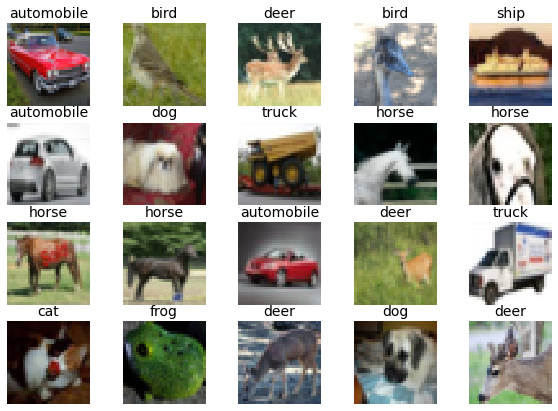

In [115]:
disp_20_random(x_train, y_train)

### 20 random validation images

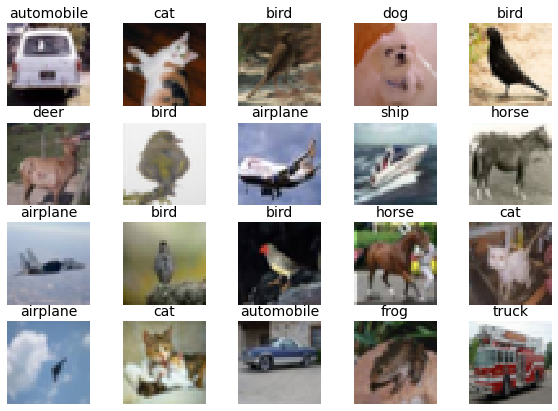

In [116]:
disp_20_random(x_val, y_val)

### 20 random test images

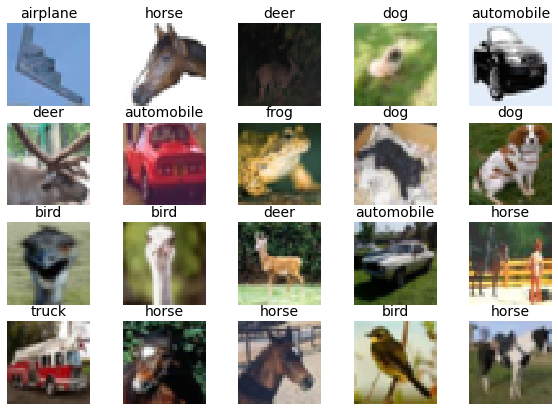

In [117]:
disp_20_random(X_test, y_test)

## MLP

In [118]:
# mlp for multiclass classification
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

This is the multilayer perceptron neural network. I have included 2 hidden layers, 1 flatten layer before an input layer, 1 input layer and 1 output layer specifically with sigmoid activation and 10 neurons as there are 10 distinct classes. There are dropout layers placed after every hidden layer as I followed a similar pattern shown in  [Improving neural networks by preventing co-adaptation of feature detectors](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1207.0580.pdf). It also states using dropout layers and small learning rate would result in lower error. Though in my grid search shows that a dropout rate of 0.01 and an Exponential learning rate provided the best accuracy with low loss value which is an optimal model with 100 epochs. Though in some training, there was high validation accuracy and high validation loss which is odd and in some case a low validation accuracy and high validation loss which indicates over-fitting. I had  chosen sparse_categorical_crossentrophy as the loss since we are working with a multiclass classification and instead of using categorical_crossentropy which would use more memory and increase in computation time.

In [119]:
def create_model(kernel_init = 'he_uniform', dropout_rate = 0.01, learning_rate_scheduler='constant'):
    # Define model
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Input(shape=(32, 32, 3), name="Input"))
    model.add(layers.Dense(512, activation='relu', name="hidden_1", kernel_initializer = kernel_init))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(172, activation='relu', name="hidden_2", kernel_initializer = kernel_init))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(10, activation='softmax', name="predictions"))

    if learning_rate_scheduler == 'constant':
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,
                                            momentum=0.9)

    if learning_rate_scheduler == 'exponential_decay':
        initial_learning_rate = 0.1
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=1000,
            decay_rate=0.96,
            staircase=True)

        optimizer = tf.keras.optimizers.SGD(lr_schedule)

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [120]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", mode='min', patience = 6, restore_best_weights = True)

## Grid Search

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

early_stopping = keras.callbacks.EarlyStopping(monitor="loss", mode='min', patience = 6, restore_best_weights = True)

#create model
model = KerasClassifier(build_fn=create_model)

#define the grid search parameters
parameter_space = {
    'dropout_rate' : [0.01, 0.05],
    'learning_rate_scheduler': ['constant', 'exponential_decay'],
    'kernel_init' : ['he_uniform', 'he_normal']
}

grid = GridSearchCV(estimator=model, param_grid=parameter_space, cv=3)
result = grid.fit(x_val, y_val, epochs = 100,callbacks = [early_stopping])

#results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
params = result.cv_results_['params']
for mean, param in zip(means, params):
    print("mean: %f with: %r" % (mean, param))

Best: 0.411200 using {'dropout_rate': 0.01, 'kernel_init': 'he_normal', 'learning_rate_scheduler': 'constant'}
mean: 0.392000 with: {'dropout_rate': 0.01, 'kernel_init': 'he_uniform', 'learning_rate_scheduler': 'constant'}
mean: 0.398933 with: {'dropout_rate': 0.01, 'kernel_init': 'he_uniform', 'learning_rate_scheduler': 'exponential_decay'}
mean: 0.411200 with: {'dropout_rate': 0.01, 'kernel_init': 'he_normal', 'learning_rate_scheduler': 'constant'}
mean: 0.384667 with: {'dropout_rate': 0.01, 'kernel_init': 'he_normal', 'learning_rate_scheduler': 'exponential_decay'}
mean: 0.395333 with: {'dropout_rate': 0.05, 'kernel_init': 'he_uniform', 'learning_rate_scheduler': 'constant'}
mean: 0.338800 with: {'dropout_rate': 0.05, 'kernel_init': 'he_uniform', 'learning_rate_scheduler': 'exponential_decay'}
mean: 0.395733 with: {'dropout_rate': 0.05, 'kernel_init': 'he_normal', 'learning_rate_scheduler': 'constant'}
mean: 0.402133 with: {'dropout_rate': 0.05, 'kernel_init': 'he_normal', 'learning_rate_scheduler': 'exponential_decay'}

The grid search uses the default scoring metrics to find the best parameters and in this case it is the mean of all the cvs accuracy. The early stopping methods evaluates on the loss of the model in the training per epochs this will stop the training if the loss increases after six epochs in a row and returns the model with the minimum epoch loss. I choose loss since the lower the loss the higher the accuracy and the better generalisation rather than overfitting. Then prints the mean and stdev of the results of each parameter combinations which is six since there are six possible combinations given 3 unique parameters and 2 selected values per parameters. In this case the best parameters include dropout_rate of 0.01, kernel_init as he_normal and a constant learning rate scheduler. I set the cv as three which should be enough for generalisation since five would increase the time of training and since I couldn`t do n_jobs=-1 to use all cores it would take too long and it is already long enough to run.

## Build Model with best parameter

When building the model with the best parameter I implemented a different early stopping method and it is to find the best validation accuracy since I applied validation data to the training algorithm. The best validation accuracy provides the best result when training with a data set outside of the training set which will improve the test accuracy when evaluting the model.

In [121]:
import time
import os

# To save time on training, save the model pretrained onto a folder
if os.path.exists('Andily_Theoridho-MLP'):
    mlp_model =  tf.keras.models.load_model('Andily_Theoridho-MLP')
    mlp_model.summary()
    mlp_model.fit(x_train, y_train,
                  epochs=1,
                  validation_data=(x_val, y_val),
                  shuffle=True,
                  callbacks = [early_stopping])

else:
    mlp_model = create_model(kernel_init='he_normal',
                             dropout_rate=0.01,
                             learning_rate_scheduler='constant',)
    start_mlp = time.time()
    mlp_model.fit(x_train, y_train,
              epochs=100,
              validation_data=(x_val, y_val),
              shuffle=True,
              callbacks = [early_stopping])
    end_mlp = time.time()
    mlp_model.summary()
    mlp_model.save('Andily_Theoridho-MLP')

Epoch 1/100
1329/1329 [==============================] - 5s 3ms/step - loss: 1.8944 - accuracy: 0.3072 - val_loss: 1.8017 - val_accuracy: 0.3557
Epoch 2/100
1329/1329 [==============================] - 4s 3ms/step - loss: 1.7443 - accuracy: 0.3723 - val_loss: 1.7225 - val_accuracy: 0.3841
Epoch 3/100
1329/1329 [==============================] - 4s 3ms/step - loss: 1.6675 - accuracy: 0.4047 - val_loss: 1.6114 - val_accuracy: 0.4171
Epoch 4/100
1329/1329 [==============================] - 4s 3ms/step - loss: 1.6093 - accuracy: 0.4226 - val_loss: 1.6176 - val_accuracy: 0.4159
Epoch 5/100
1329/1329 [==============================] - 4s 3ms/step - loss: 1.5686 - accuracy: 0.4386 - val_loss: 1.5849 - val_accuracy: 0.4357
Epoch 6/100
1329/1329 [==============================] - 4s 3ms/step - loss: 1.5472 - accuracy: 0.4457 - val_loss: 1.5656 - val_accuracy: 0.4341
Epoch 7/100
1329/1329 [==============================] - 4s 3ms/step - loss: 1.5130 - accuracy: 0.4566 - val_loss: 1.5540 - val_ac

## Evaluate the model

 Evaluating after loading the data and training with 1 epochs provides different result compared to previous training. It would be better to run with out the model folder for predictions.

In [122]:
loss, acc = mlp_model.evaluate(X_test, y_test, verbose=2)
print('Trained model, accuracy: {:5.2f}%'.format(100 * acc))

313/313 - 1s - loss: 1.4491 - accuracy: 0.4968 - 515ms/epoch - 2ms/step
Trained model, accuracy: 49.68%


## CNN

In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
import matplotlib.pyplot as plt

This is the convolution neural network with 3 convolutional layers, pooling layers in between, 2 fully layers, 1 <em>batch normalisation</em> layer and final output layer. The convolution layers is similar to a filter layers that observes the input value and filter value to a feature map. The two fully connected layer is to connect last pooling layer and the final output layer. The pooling layers is added to reduce the sensitivity of the filter layer and provide a better feature mapping. As stated in the lab sheet, the batch normalisation layer helps to control the numerical values of the network weights. Here I performed a grid search on the activation function and the kernel size and found ReLu and kernel size of (3, 3) as an optimal parameter. I had  chosen sparse_categorical_crossentrophy as the loss since we are working with a multiclass classification. Here I reduced the number of epochs to 20. In this model I used sparse_categorical_crossentropy as it is good for multi-class classification due to the use of category index of the most likely matching category and it saves memory and computation time compared to using categorical_crossentropy. The SGD optimiser is used as it was known to be best for learning rate scheduling from MLP model.

In [124]:
# Create the model
def create_model_cnn(kernel_number = 256, activation_func='relu', kernel_size=(3,3)):
    model = Sequential()
    model.add(Conv2D(filters = kernel_number, kernel_size=kernel_size, activation=activation_func, input_shape=(32, 32, 3), name='input_layer'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters = kernel_number, kernel_size=kernel_size, activation=activation_func, name='hidden_layer1'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters = kernel_number, kernel_size=kernel_size, activation=activation_func, name='hidden_layer2'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation=activation_func, name='fully_connected_layer_1'))
    model.add(Dense(128, activation=activation_func, name='fully_connected_layer_2'))
    model.add(keras.layers.BatchNormalization())
    model.add(Dense(10, activation='softmax'))

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,
                                        momentum=0.9)

    # Compile the model
    model.compile(loss=sparse_categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

    return model

## Grid Search CNN

early_stopping = keras.callbacks.EarlyStopping(monitor="loss", mode='min', patience = 6, restore_best_weights = True)

#create model
model = KerasClassifier(build_fn=create_model_cnn)

#define the grid search parameters
parameter_space = {
    'kernel_size' : [(4,4), (3,3)],
    'activation_func' : ['relu', 'sigmoid'],
    'kernel_number' : [256, 512],
}

grid = GridSearchCV(estimator=model, param_grid=parameter_space, cv=3)
grid_result = grid.fit(x_val, y_val, epochs = 100, callbacks = [early_stopping])

#results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean, param in zip(means, params):
    print("mean: %f with: %r" % (mean param))

Best: 0.546533 using {'activation_func': 'relu', 'kernel_number': 512, 'kernel_size': (3, 3)}
mean: 0.503600 with: {'activation_func': 'relu', 'kernel_number': 256, 'kernel_size': (4, 4)}
mean: 0.504400 with: {'activation_func': 'relu', 'kernel_number': 256, 'kernel_size': (3, 3)}
mean: 0.527200 with: {'activation_func': 'relu', 'kernel_number': 512, 'kernel_size': (4, 4)}
mean: 0.546533 with: {'activation_func': 'relu', 'kernel_number': 512, 'kernel_size': (3, 3)}
mean: 0.204933 with: {'activation_func': 'sigmoid', 'kernel_number': 256, 'kernel_size': (4, 4)}
mean: 0.255867 with: {'activation_func': 'sigmoid', 'kernel_number': 256, 'kernel_size': (3, 3)}
mean: 0.125600 with: {'activation_func': 'sigmoid', 'kernel_number': 512, 'kernel_size': (4, 4)}
mean: 0.229867 with: {'activation_func': 'sigmoid', 'kernel_number': 512, 'kernel_size': (3, 3)}

Looking at the mean score of each cvs there is an improvement compared to the MLP and by the best score it is a 33% improvement. In here the three parameters tuned were the kernel_size, activation function and kernel_number. The results shows with sigmoid function the average mean score are much lower compared to the ReLu function and looking the at the kernel number the higher the kernel number the better the score. The kernel size were only a small increment from 3 to 4 but the results shows that using the smaller kernel size gives the best score. Similar to the previous grid search the early stopping call back is calculating on the minimum loss and stops training once the loss increases six times in a row.

In [125]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", mode='min', patience = 6, restore_best_weights = True)

In [126]:
if os.path.exists('Andily_Theoridho-CNN'):
    cnn_model = tf.keras.models.load_model('Andily_Theoridho-CNN')
    cnn_model.summary()
    cnn_model.fit(x_train, y_train,
                  epochs = 1,
                  validation_data = (x_val, y_val),
                  shuffle=True,
                  callbacks = [early_stopping])

else:
    cnn_model = create_model_cnn(kernel_number = 512,
                                 kernel_size = (3,3),
                                 activation_func = 'relu')
    start_cnn = time.time()
    history_mlp = cnn_model.fit(x_train, y_train,
                                epochs = 100,
                                validation_data = (x_val, y_val),
                                shuffle=True,
                                callbacks = [early_stopping])
    end_cnn = time.time()
    cnn_model.summary()
    cnn_model.save('Andily_Theoridho-CNN')

Epoch 1/100
1329/1329 [==============================] - 43s 32ms/step - loss: 1.4864 - accuracy: 0.4643 - val_loss: 3.6870 - val_accuracy: 0.2505
Epoch 2/100
1329/1329 [==============================] - 42s 32ms/step - loss: 1.1230 - accuracy: 0.6069 - val_loss: 1.1395 - val_accuracy: 0.5956
Epoch 3/100
1329/1329 [==============================] - 42s 32ms/step - loss: 0.9385 - accuracy: 0.6756 - val_loss: 1.5318 - val_accuracy: 0.5260
Epoch 4/100
1329/1329 [==============================] - 44s 33ms/step - loss: 0.8041 - accuracy: 0.7233 - val_loss: 0.9437 - val_accuracy: 0.6901
Epoch 5/100
1329/1329 [==============================] - 43s 32ms/step - loss: 0.6966 - accuracy: 0.7592 - val_loss: 0.9618 - val_accuracy: 0.6764
Epoch 6/100
1329/1329 [==============================] - 43s 33ms/step - loss: 0.5913 - accuracy: 0.7953 - val_loss: 0.8975 - val_accuracy: 0.7123
Epoch 7/100
1329/1329 [==============================] - 43s 32ms/step - loss: 0.4992 - accuracy: 0.8279 - val_loss: 0

## Evaluate the model

 Evaluating after loading the data and training with 1 epochs provides different result compared to previous training. It would be better to run with out the model folder for predictions.

In [127]:
loss, acc = cnn_model.evaluate(X_test, y_test, verbose=2)
print('Trained model, accuracy: {:5.2f}%'.format(100 * acc))

313/313 - 3s - loss: 0.9426 - accuracy: 0.7317 - 3s/epoch - 10ms/step
Trained model, accuracy: 73.17%


## Perfomance Comparison

In [128]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

mlp_predict =np.argmax(mlp_model.predict(X_test), axis = 1)

cnn_predict =np.argmax(cnn_model.predict(X_test), axis = 1)

def performance(y_test, prediction, start, end):
    """
    This function calculates the accuracy, F1 score, precision and computation time as time taken to train a model and also builds and display a confusion matrix
    :param y_test: The true classes from data set
    :param prediction: The predicted classes from classification
    :param start: The beginning of the training time
    :param end: The end of the training time
    :return: None
    """
    print("Accuracy of the mlp model:", accuracy_score(y_test, prediction))
    print("F1 score: ", round(f1_score(y_test, prediction, average='weighted'),4))
    print("Precision per class: ", round(precision_score(y_test, prediction, average='weighted'), 4))
    print("Time taken to train MLP: ", round((end - start), 1), 'seconds')

    fig, ax = plt.subplots(figsize=(15, 15))
    ConfusionMatrixDisplay(confusion_matrix(y_test, prediction), display_labels=class_names).plot(ax=ax)
    plt.show()

### MLP Performance

Accuracy of the mlp model: 0.4968
F1 score:  0.4953
Precision per class:  0.5008
Time taken to train MLP:  89.8 seconds


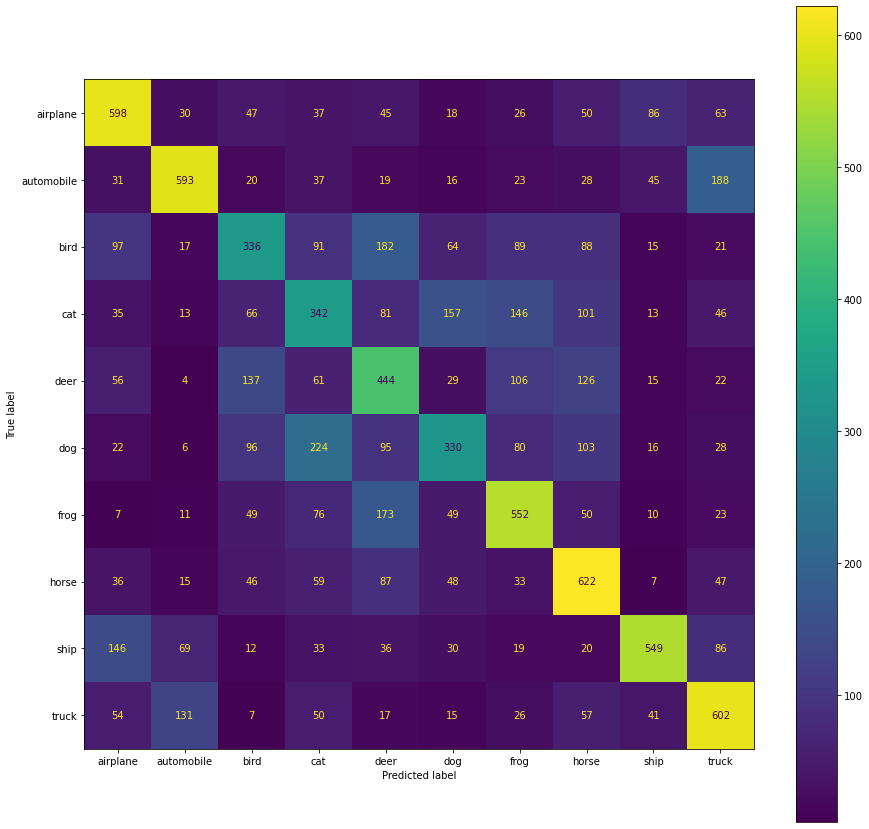

In [129]:
performance(y_test, prediction=mlp_predict, start=start_mlp, end=end_mlp)

### CNN Performance

Accuracy of the mlp model: 0.7317
F1 score:  0.7311
Precision per class:  0.7352
Time taken to train MLP:  646.5 seconds


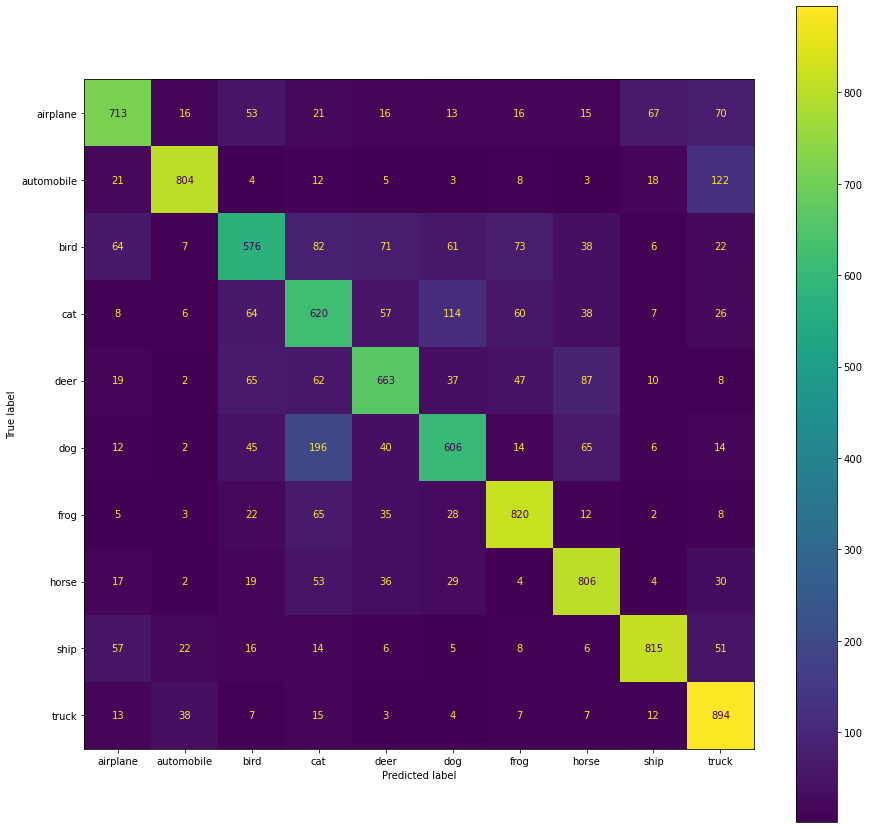

In [130]:
performance(y_test, prediction=cnn_predict, start=start_cnn, end=end_cnn)

All of the perimeter for comparing performance was much higher in the CNN model compared to the MLP model but the computation time is significantly higher on the CNN compared to the MLP. The accuracy increase by 48%, F1 increase by 47.8% and the precision increased by 46.8% which is a very good result but at the cost of increased computation time by about 620%. In both model the precision is higher than both accuracy and F1 which means there are more true positive prediction are correct.It is possible to reduce the kernel number in cnn to reduce the computation time but it will also reduce the accuracy. Looking at the confusion matrix the MLP model struggles to differentiate between automobiles and truck, deer and frog, cats and dogs and deer and birds. The CNN confusion matrix shows a more promising result but also struggles with classifying trucks and automobile and cats and dogs.

In [141]:
def disp_10(x_data, y_data):
    """
    This function visualises 10 random images from a set of x_data and y_data
    :param x_data: array with (number of images, 32, 32, 3)
    :param y_data: array of classes corresponding with the x_data
    :return: None
    """
    fig = plt.figure(figsize=(10, 7))
    rows = 2
    columns = 5
    counter = 1
    for i in range(10):
        fig.add_subplot(rows, columns, counter)
        counter += 1
        plt.imshow(x_data[i], interpolation='none')
        plt.axis('off')
        plt.title(class_names[y_data[i]], fontdict={'fontsize': 14})

In [151]:
def correct_incorrect(y_test, prediction, X_test):
    """
    This function retuns the array of correctly classified images and incorrectly classified images in their x and y data set
    :param y_test: The true class label
    :param prediction: The predicted class label
    :param X_test: The array of images in the x_test data set
    :return: correctly_x, correct_y, incorrect_x, incorrect_y
    """
    correctly_x = []
    correct_y = []
    incorrect_x = []
    incorrect_y = []

    for index in range(len(prediction)):
        if prediction[index] == y_test[index]:
            correct_y.append(prediction[index])
            correctly_x.append(X_test[index])
        else:
            incorrect_y.append(prediction[index])
            incorrect_x.append(X_test[index])
    return [correctly_x, correct_y], [incorrect_x, incorrect_y]

## Some correctly and incorrectly classified images for mlp

In [152]:
mlp_correct, mlp_incorrect = correct_incorrect(y_test, mlp_predict, X_test)

### Correctly displayed images from MLP

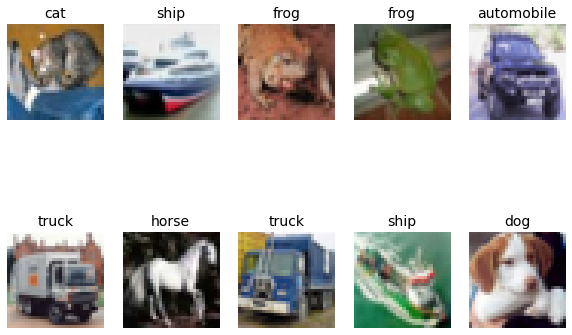

In [153]:
disp_10(mlp_correct[0], mlp_correct[1])

### Incorrectly displayed images from MLP

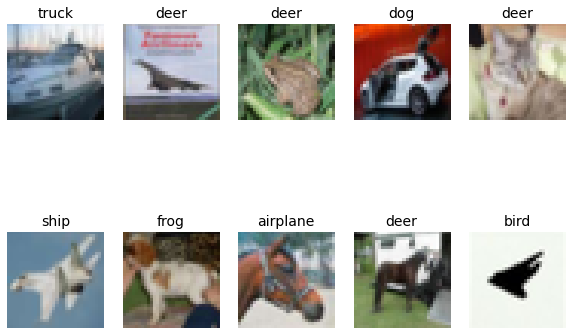

In [154]:
disp_10(mlp_incorrect[0], mlp_incorrect[1])

## Some correctly and incorrectly classified images for cnn

In [155]:
cnn_correct, cnn_incorrect = correct_incorrect(y_test, cnn_predict, X_test)

### Correctly displayed images from CNN

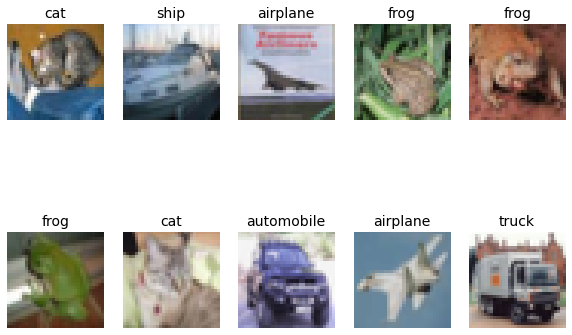

In [156]:
disp_10(cnn_correct[0], cnn_correct[1])

### Incorrectly displayed images from CNN

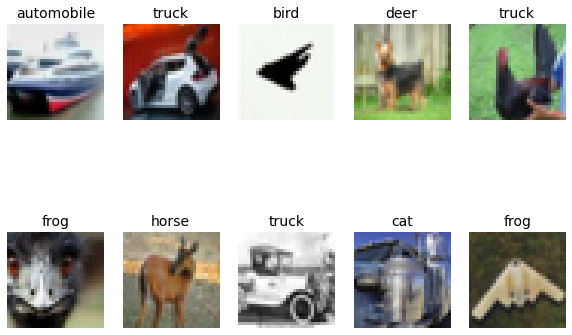

In [157]:
disp_10(cnn_incorrect[0], cnn_incorrect[1])